# Using Machine Learning Tools Assignment 1

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of predicting bike rental demand. A data set has been provided containing records of bike rentals in Seoul, collected during 2017-18.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code and some require graphical results. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (with the correct results displayed) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code is written to run correctly on the original data file.

When creating graphical output, label is clearly, with appropriate titles, xlabels and ylabels, as appropriate.

Chapter 2 of the textbook is based on a similar workflow to this assignment, so you may look there for some further background and ideas. You can also use any other general resources on the internet that are relevant although do not use ones which directly relate to these questions with this dataset (which would normally only be found in someone else's assignment answers). If you take a large portion of code or text from the internet then you should reference where this was taken from, but we do not expect any references for small pieces of code. Taking, and adapting, small portions of code is expected and is common practice when solving real problems.

## The following code imports some of the essential libraries that you will need. You should not need to modify it, but you are expected to import other libraries as needed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**STEP01:** 
Load the data set from the csv file (SeoulBikeData.csv) into a DataFrame, and summarise it with the pandas functions `describe()` and `info()`.

Download the data set from MyUni using the link provided on the assignment page. A paper that describes one related version of this dataset is: Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020. Feel free to look at this if you want more information about the dataset.

The data is stored in a CSV (comma separated variable) file and contains the following information 

 - Date: year-month-day
 - Rented Bike Count: Count of bikes rented at each hour
 - Hour: Hour of the day
 - Temperature: Temperature in Celsius
 - Humidity: %
 - Windspeed: m/s
 - Visibility: 10m
 - Dew point temperature: Celsius
 - Solar radiation: MJ/m2
 - Rainfall: mm
 - Snowfall: cm
 - Seasons: Winter, Spring, Summer, Autumn
 - Holiday: Holiday/No holiday
 - Functional Day: NoFunc(Non Functional Hours), Fun(Functional hours)

**Load the data set from the csv file into a DataFrame, and summarise it with at least two appropriate pandas functions.**

_Points:_ 2

In [2]:
# Load the data from the CSV file
data = pd.read_csv('SeoulBikeData.csv')

# Summarise the data with describe()
print(data.describe())

# Summarise the data with info()
print(data.info())

# The following code is used by the autograder, don't change it
step1_sol = data.shape

       Rented Bike Count         Hour  Temperature (C)  Humidity (%)  \
count        8760.000000  8760.000000      8760.000000   8760.000000   
mean          704.602055    11.502740        12.914361     58.240183   
std           644.997468     6.922779        12.347109     20.584774   
min             0.000000     0.000000       -17.800000    -26.000000   
25%           191.000000     6.000000         3.500000     42.000000   
50%           504.500000    12.000000        13.700000     57.000000   
75%          1065.250000    18.000000        22.500000     74.000000   
max          3556.000000    24.000000       306.000000    309.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature (C)  \
count       8759.000000       8760.000000                8759.000000   
mean           1.953237       1436.442808                   4.074369   
std           21.376612        608.827735                  13.061011   
min            0.000000       -678.000000                 -30.6

grader.check("step01")

**STEP02:** To get a feeling for the data it is a good idea to do some form of simple visualisation. Display a set of histograms for the features as they are right now, prior to any cleaning steps.

_Points:_ 0

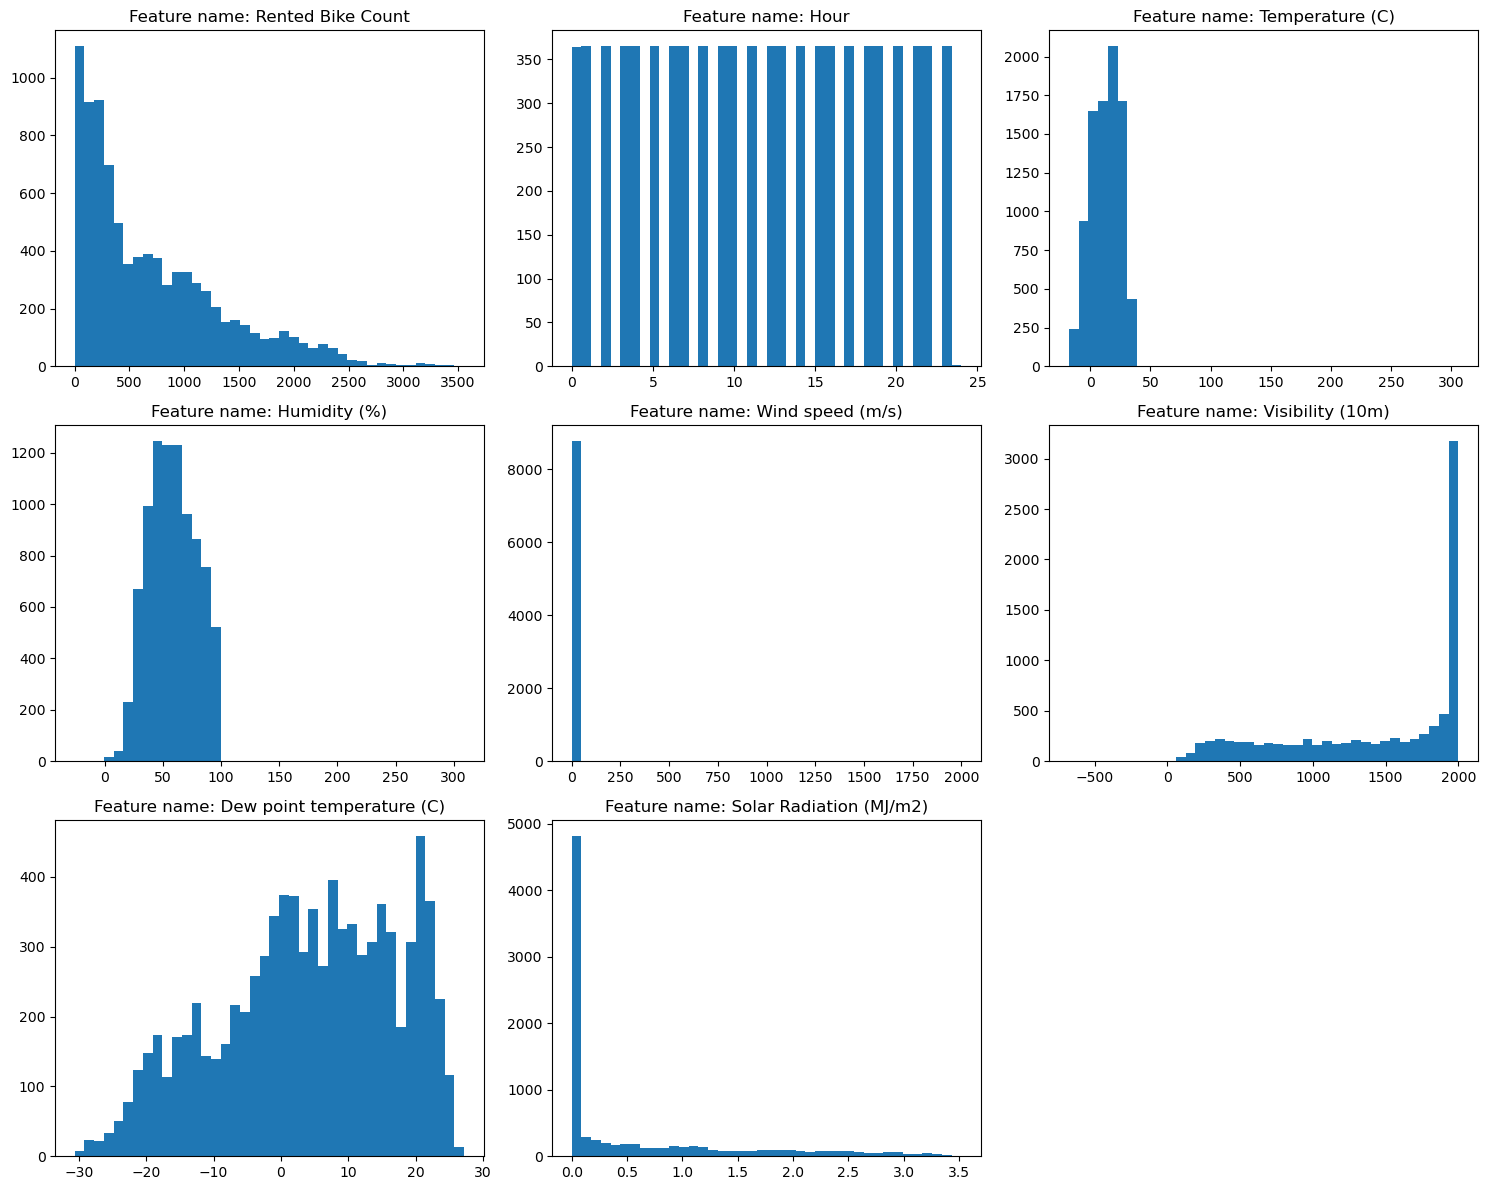

In [3]:
# Visualise features with histograms (only numeric columns)
plt.figure(figsize=(15,12))
numeric_cols = data.select_dtypes(include=['number']).columns
nfeat = len(numeric_cols)
ncol = 3
nrow = int(np.ceil(nfeat/ncol))

for n, col in enumerate(numeric_cols):
    plt.subplot(nrow, ncol, n+1)
    plt.hist(data[col], bins=40)
    plt.title(f'Feature name: {col}')
plt.tight_layout()
plt.show()

grader.check("step02")

**STEP03:** The "Functioning Day" feature records whether the bike rental was open for business on that day. For this assignment we are only interested in predicting demand on days when the business is open, so remove rows from the DataFrame where the business is closed. After doing this, delete the Functioning Day feature from the DataFrame and verify that this worked. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [4]:
data = data[data["Functioning Day"] == "Yes"]
data = data.drop("Functioning Day", axis=1)

# Verification
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")
print(f"Columns: {data.columns.tolist()}")
print(f"'Functioning Day' in columns: {'Functioning Day' in data.columns}")


# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step3_data = data.copy()

Number of rows: 8465, Number of columns: 13
Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature (C)', 'Humidity (%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature (C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday']
'Functioning Day' in columns: False


grader.check("step03")

**STEP04:** 
The goal is to predict bike rental demand using historical data. To achieve this, you will use regression techniques with "Bike Rental Count" as the target feature for this prediction, *but for this*, it is important that all other features in the data are numerical. Two of the features in the data, "Holiday" and "Season", need to be converted to numerical format. Write code to convert the "Holiday" feature to 0 or 1 from its current format. For the "Season" feature, add 4 new columns, labeled as "Winter", "Spring", "Summer", and "Autumn" then remove the "Season" column. Each of these columns should store a 0 or 1, depending on the corresponding season in each row. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [5]:
# Convert Holiday feature to 0 or 1
data['Holiday'] = data['Holiday'].map({'No Holiday': 0, 'Holiday': 1})

# Convert Seasons feature to one-hot encoding
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season_name in seasons:
    data[season_name] = (data['Seasons'] == season_name).astype(int)

# Remove the original Seasons column
data = data.drop('Seasons', axis=1)

# Verification
print("Holiday unique values:", data['Holiday'].unique())
print("Season columns check:")
for season in seasons:
    print(f"{season} values:", data[season].unique())

# The following code is used by the autograder, don't change it
step4_data = data.copy()

Holiday unique values: [0 1]
Season columns check:
Winter values: [1 0]
Spring values: [0 1]
Summer values: [0 1]
Autumn values: [0 1]


grader.check("step04")

**STEP05**: It is known that bike rentals depend strongly on whether it's a weekday or a weekend. Replace the Date feature with a Weekday feature that stores 0 or 1 depending on whether the date represents a weekend or weekday. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [6]:
# Convert Date to Weekday (0 for weekday, 1 for weekend)
data['Weekday'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.dayofweek
data['Weekday'] = (data['Weekday'] >= 5).astype(int)  # 5, 6 are weekend days (Saturday, Sunday)

# Drop the original Date column
data = data.drop('Date', axis=1)

# Verification
print("Weekday unique values:", data['Weekday'].unique())

# The following code is used by the autograder, don't change it
step5_data = data.copy()

Weekday unique values: [0 1]


grader.check("step05")

**STEP06** Convert all the remaining data to numerical format, with any non-numerical entries set to NaN.

_Points:_ 3

In [7]:
# Convert all remaining data to numerical format, with non-numerical entries set to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Verify
print(data.dtypes)  # Check data types
print(data.isna().sum())  # Check NaN count

# The following code is used by the autograder
# make sure your variable that contains that DataFrame from this step is the one assigned to step6_data
step6_data = data.copy()

Rented Bike Count              int64
Hour                           int64
Temperature (C)              float64
Humidity (%)                   int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature (C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Holiday                        int64
Winter                         int64
Spring                         int64
Summer                         int64
Autumn                         int64
Weekday                        int64
dtype: object
Rented Bike Count             0
Hour                          0
Temperature (C)               0
Humidity (%)                  0
Wind speed (m/s)              1
Visibility (10m)              0
Dew point temperature (C)     1
Solar Radiation (MJ/m2)       0
Rainfall(mm)                 25
Snowfall (cm)                23
Holiday                       0
Winter                        0
Spring    

grader.check("step06")

**STEP07** Examin the data and identify problematic entries. Set any problematic values in the numerical data to `np.nan` and check that this has worked. Once this is done, specify a **sklearn *pipeline* that will perform imputation** to replace problematic entries (nan values) with an appropriate **median** value ***and* any other pre-processing** that you think should be used. Just specify the pipeline - do ***not*** run it now.

_Points:_ 3

In [8]:
# Get all numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Check for negative values in all numeric columns
for col in numeric_cols:
    negative_count = (data[col] < 0).sum()
    print(f"Number of negative values in {col}: {negative_count}")
    
    # Set negative values to NaN for all numeric columns
    data.loc[data[col] < 0, col] = np.nan

# Check that this worked
print("Checking NaN values:")
print(data.isna().sum())

pipeline_step7 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# The following code is used by the autograder
# make sure your variable that contains the solutions from this step is the one assigned to step7_data as follows
step7_data = [data.copy(),pipeline_step7]

Number of negative values in Rented Bike Count: 0
Number of negative values in Hour: 0
Number of negative values in Temperature (C): 1433
Number of negative values in Humidity (%): 3
Number of negative values in Wind speed (m/s): 0
Number of negative values in Visibility (10m): 1
Number of negative values in Dew point temperature (C): 3123
Number of negative values in Solar Radiation (MJ/m2): 0
Number of negative values in Rainfall(mm): 0
Number of negative values in Snowfall (cm): 0
Number of negative values in Holiday: 0
Number of negative values in Winter: 0
Number of negative values in Spring: 0
Number of negative values in Summer: 0
Number of negative values in Autumn: 0
Number of negative values in Weekday: 0
Checking NaN values:
Rented Bike Count               0
Hour                            0
Temperature (C)              1433
Humidity (%)                    3
Wind speed (m/s)                1
Visibility (10m)                1
Dew point temperature (C)    3124
Solar Radiation 

grader.check("step07")

**STEP08:** Generate a pre-processed version of the entire dataset by applying the pipeline defined in STEP07. Then, calculate the correlation of each feature with the target using either the pandas function corr() or numpy corrcoef() and find the 3 attributes that are the most correlated with bike rentals. 

_Points:_ 3

In [9]:
# Apply the pipeline to preprocess the data
# First, separate the target variable
X = data.drop('Rented Bike Count', axis=1)
y = data['Rented Bike Count']

# Apply the preprocessing pipeline
preprocessed_data = pd.DataFrame(
    pipeline_step7.fit_transform(X),
    columns=X.columns
)

# Add the target variable back to the preprocessed data
preprocessed_data['Rented Bike Count'] = y

# Calculate correlation with the target
correlation = preprocessed_data.corr()['Rented Bike Count'].abs().sort_values(ascending=False)        

# top_3 should be an array of 3 strings ['attribute name', 'attribute name','attribute name']
top_3 = correlation[1:4].index.tolist()
print(top_3)
# The following code is used by the autograder
# make sure your variable that contains a list of the names of the top 3 attributes is assigned to step3_data
step8_data = top_3.copy()

['Winter', 'Hour', 'Temperature (C)']


grader.check("step08")

**STEP09:** Divide the data into training and test sets using where 20% of the data is kept for testing. Create a pipeline that includes the linear regression model in addition to the pipeline defined in STEP07. Fit the pipeline to the training set and calculate the `rmse` of the fit to evaluate its performance. As a comparison, compute the `rmse` that would be obtained by predicting the mean value of bike rentals for all training examples.

_Points:_ 3

In [10]:
# Split data into training and test sets
X = data.drop('Rented Bike Count', axis=1)
y = data['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline by adding LinearRegression to the pipeline from Step 7
pipeline_step9 = make_pipeline(pipeline_step7, LinearRegression())

# Fit the pipeline to the training data
pipeline_step9.fit(X_train, y_train)

# Predict on training data
y_train_pred = pipeline_step9.predict(X_train)

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate baseline (mean prediction) RMSE
y_mean = np.full_like(y_train, y_train.mean())
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_mean))

print("RMSE for training data:", rmse_train)
print("RMSE for baseline (predicting mean):", rmse_baseline)
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step9_data = [rmse_train,rmse_baseline]

RMSE for training data: 447.37422819154807
RMSE for baseline (predicting mean): 646.170499547999


Text(0, 0.5, 'Predicted')

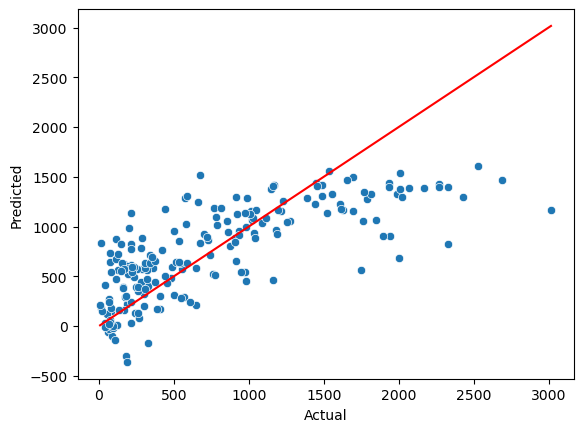

In [11]:
#The following code will show a visualisation of the fit for your linear regression.
# I will use your pipeline_step9 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step9.predict(X_train[:subset_size])

# Then I create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
# A perfect solution would look like the red line
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step09")

**STEP10:**  Fit a Kernel Ridge regression model (imported from sklearn.kernel_ridge) to the X_train data from STEP09. Build a new pipeline that includes the Kernel Ridge regression model in addition to the pipeline defined in STEP07, and fit it to the training data using default settings. Generate a scatter plot of the predicted values against the actual values for the training data, and calculate the RMSE of the fit to the training data.

_Points:_ 3

In [12]:
from sklearn.kernel_ridge import KernelRidge
# you can use make_pipline to create a new pipiline by adding a model at the end of pipeline_step7 or you can simply create a new pipeline. 
# whatever you end up doing, make sure it is called pipeline_step10
pipeline_step10 = make_pipeline(pipeline_step7, KernelRidge())

# Fit the pipeline to the training data
pipeline_step10.fit(X_train, y_train)

# make predictions on the training data
y_pred_train_KR = pipeline_step10.predict(X_train)

# calculate rmse for training data
rmse_train_KR = np.sqrt(mean_squared_error(y_train, y_pred_train_KR))

print('Kernel Ridge model RMSE on training data:', rmse_train_KR)
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step10_data = [rmse_train_KR, pipeline_step10]

Kernel Ridge model RMSE on training data: 857.3655401584411


Text(0, 0.5, 'Predicted')

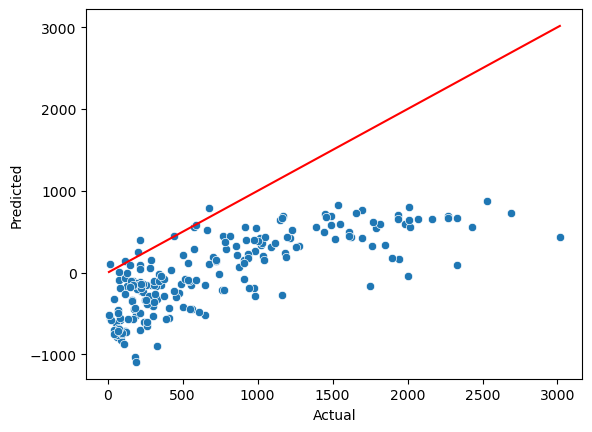

In [13]:
# I will use your pipeline_step10 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step10.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step10")

**STEP11:** Fit a Support Vector Regression (from sklearn.svm import SVR). As you did for STEP10, create a new pipeline using the pipelinr from STEP07 and this model and fit it to your training data, using the default settings. Again, calculate the RMSE of the fit to the training data.

_Points:_ 4

In [14]:
from sklearn.svm import SVR
# you can use make_pipline to create a new pipiline by adding a model at the end of pipeline_step7 or you can simply create a new pipeline. 
# whatever you end up doing, make sure it is called pipeline_step11
pipeline_step11 = make_pipeline(pipeline_step7, SVR())

# Fit the pipeline to the training data
pipeline_step11.fit(X_train, y_train)

# make predictions on the training data
y_pred_train_SVR = pipeline_step11.predict(X_train)

# calculate rmse for training data
rmse_train_SVR = np.sqrt(mean_squared_error(y_train, y_pred_train_SVR))

print('Support Vector Regression model RMSE on training data:', rmse_train_SVR)
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step11_data = [rmse_train_SVR, pipeline_step11]

Support Vector Regression model RMSE on training data: 549.1545271406939


Text(0, 0.5, 'Predicted')

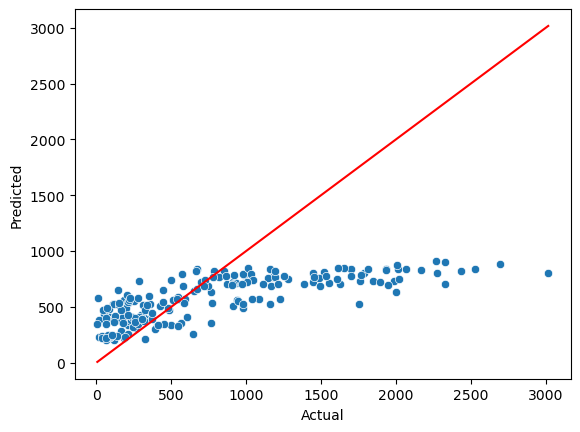

In [15]:
# use your pipeline_step10 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step11.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step11")

**STEP12:** Perform a 10 fold cross validation for each of the three model (LinearRegression,KernelRidge,SVR). This splits the training set (that we've used above) into 10 equal size subsets, and uses each in turn as the validation set while training a model with the other 9. You should therefore have 10 rmse values for each cross validation run. Find the mean and standard deviation of the rmse values obtained for each model for the validation splits.

_Points:_ 5

In [16]:
# you might need some or all of the following imports
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Create the three pipelines for cross-validation
pipeline_LR = make_pipeline(pipeline_step7, LinearRegression())
pipeline_KR = make_pipeline(pipeline_step7, KernelRidge())
pipeline_SVR = make_pipeline(pipeline_step7, SVR())

# Define the cross-validation method
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Function to calculate negative RMSE for scoring
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

# Perform cross-validation for Linear Regression
scores_LR = cross_val_score(pipeline_LR, X_train, y_train, cv=kf, scoring=rmse_scorer)
rmse_LR_scores = -scores_LR  # Convert back to positive RMSE values
rmse_LR_mean = np.mean(rmse_LR_scores)
rmse_LR_std = np.std(rmse_LR_scores)
print('Linear Regression CV Scores:') 
print(f'Mean: {rmse_LR_mean:.2f}, Std: {rmse_LR_std:.2f}\n')

# Perform cross-validation for Kernel Ridge Regression
scores_KR = cross_val_score(pipeline_KR, X_train, y_train, cv=kf, scoring=rmse_scorer)
rmse_KR_scores = -scores_KR  # Convert back to positive RMSE values
rmse_KR_mean = np.mean(rmse_KR_scores)
rmse_KR_std = np.std(rmse_KR_scores)
print('Kernel Ridge Regression CV Scores:') 
print(f'Mean: {rmse_KR_mean:.2f}, Std: {rmse_KR_std:.2f}\n')

# Perform cross-validation for Support Vector Regression
scores_SVR = cross_val_score(pipeline_SVR, X_train, y_train, cv=kf, scoring=rmse_scorer)
rmse_SVR_scores = -scores_SVR  # Convert back to positive RMSE values
rmse_SVR_mean = np.mean(rmse_SVR_scores)
rmse_SVR_std = np.std(rmse_SVR_scores)
print('Support Vector Regression CV Scores:') 
print(f'Mean: {rmse_SVR_mean:.2f}, Std: {rmse_SVR_std:.2f}\n')

# The following code is used by the autograder
step12_data = [rmse_LR_mean, rmse_KR_mean, rmse_SVR_mean]

Linear Regression CV Scores:
Mean: 474.23, Std: 68.09

Kernel Ridge Regression CV Scores:
Mean: 871.96, Std: 32.96

Support Vector Regression CV Scores:
Mean: 557.81, Std: 24.63



grader.check("step12")

**STEP13:** Both the Kernel Ridge Regression and Support Vector Regression have hyperparameters that can be adjusted to suit the problem. Use grid search to systematically compare the generalisation performance (rmse) obtained with different hyperparameter settings (still with 10-fold CV). Use the sklearn function GridSearchCV to do this.

For KernelRidge, vary the hyperparameter alpha. (note, if you are using KernelRidge as the last step in a pipeline, alpha is refered to as kernelridge__alpha) 

For SVR, vary the hyperparameter C. (note, if you are using SVR as the last step in a pipeline, C is refered to as SVR__C)

Find the hyperparameter setting for each medel.

Finally, train and apply both models, with the best hyperparameter settings, to the test set and report the performance as rmse.

_Points:_ 5

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grids for each model
kr_param_grid = {'kernelridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
svr_param_grid = {'svr__C': [0.1, 1.0, 10.0, 100.0, 1000.0]}

# Define the GridSearchCV objects for each model
kr_cv = GridSearchCV(
    make_pipeline(pipeline_step7, KernelRidge()),
    param_grid=kr_param_grid,
    cv=10,
    scoring=rmse_scorer,
    return_train_score=True
)

svr_cv = GridSearchCV(
    make_pipeline(pipeline_step7, SVR()),
    param_grid=svr_param_grid,
    cv=10,
    scoring=rmse_scorer,
    return_train_score=True
)

# Fit the GridSearchCV objects to the training data
kr_cv.fit(X_train, y_train)
svr_cv.fit(X_train, y_train)

# Print the best hyperparameter setting for each model
print("Best hyperparameter setting for Kernel Ridge Regression:", kr_cv.best_params_)
print("Best hyperparameter setting for Support Vector Regression:", svr_cv.best_params_)

# Create pipeline using the best hyperparameter
pipeline_best_kr = kr_cv.best_estimator_
pipeline_best_svr = svr_cv.best_estimator_

# Train and apply the chosen model to the test set
kr_predictions = pipeline_best_kr.predict(X_test)
kr_rmse = np.sqrt(mean_squared_error(y_test, kr_predictions))

svr_predictions = pipeline_best_svr.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_predictions))

print("Kernel Ridge Regression RMSE on test set:", kr_rmse)
print("Support Vector Regression RMSE on test set:", svr_rmse)

# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step13_data = [kr_rmse, svr_rmse, kr_cv, svr_cv, pipeline_best_kr, pipeline_best_svr]

Best hyperparameter setting for Kernel Ridge Regression: {'kernelridge__alpha': 100.0}
Best hyperparameter setting for Support Vector Regression: {'svr__C': 1000.0}
Kernel Ridge Regression RMSE on test set: 827.2651887098007
Support Vector Regression RMSE on test set: 282.93131593843594


Text(0, 0.5, 'Predicted')

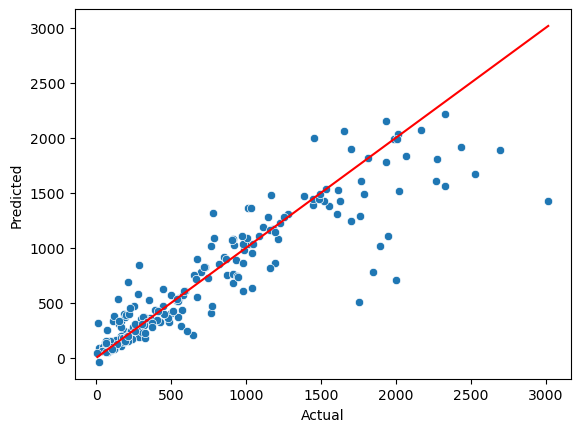

In [19]:
# use your pipeline_best_svr to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_best_svr.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step13")